In [1]:
import matplotlib.pyplot as plt
import json
import os
from core.data_processor import DataLoader
from core.model import Model

In [2]:
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 显示结果图表函数

In [3]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='正确值')
    plt.plot(predicted_data, label='预测值')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='正确值')
    # 填充预测列表，将其在图表中移动到正确的开始位置
    for i, data in enumerate(predicted_data):
        padding = [None for _ in range(i * prediction_len)]
        plt.plot(padding + data, label='预测值')
        plt.legend()
    plt.show()

# 加载实验一的配置文件

In [4]:
configs = json.load(open('test_1/config.json', 'r'))

# 数据加载器
### 创建一个 DataLoader的类 class 来加载数据，为数据加载层提供概括信息
* 传入文件名
* 确定用于训练与测试的数据百分比的分割变量
* 选择一列或多列数据来进行单维或多维分析的列变量

In [5]:
data = DataLoader(
    filename=os.path.join('data', configs['data']['filename']),
    split=configs['data']['train_test_split'],
    cols=configs['data']['columns']
)

## 1.划分训练集

In [6]:
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

## 2.划分测试集

In [7]:
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

## 3.模型构建
代码框架使用Model类和config.json文件来轻松构建模型的实例
构建网络的主函数是build_model（）函数，它接收解析的配置文件。

In [8]:
model = Model()
model.build_model(configs)

[Model] Model Compiled
Time taken: 0:00:00.829738


# 模型训练
我们创建了一个单独的运行模块，它将Model和DataLoader 抽象出来的信息组合起来并用于训练、输出和可视化。

In [9]:
model.train(
    x,
    y,
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    save_dir=configs['model']['save_dir']
)

[Model] Training Started
[Model] 2 epochs, 32 batch size
Epoch 1/2
132/132 [==============================] - 17s 94ms/step - loss: 0.0184
Epoch 2/2
132/132 [==============================] - 12s 92ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models\28112021-173034-e2.h5
Time taken: 0:00:29.558938


# 预测数据

* 第一种将以逐点方式进行预测，即我们每次仅预测单个点，将此点绘制为预测，然后沿着下一个窗口进行预测,并再次使用完整的测试数据预测下一个点。
* 对完整的序列进行预测

In [10]:
predictions_bypoint = model.predict_point_by_point(x_test)
predictions_byfull = model.predict_sequence_full(x_test, configs['data']['sequence_length'])

[Model] Predicting Point-by-Point...
[Model] Predicting Sequences Full...


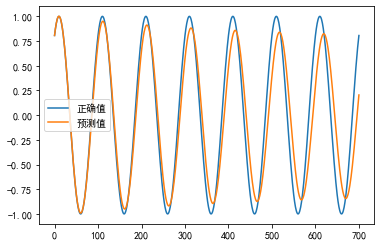

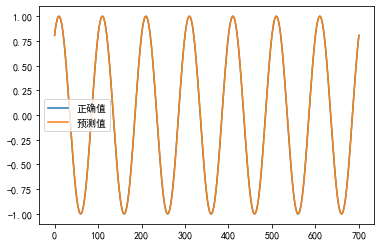

In [11]:

plot_results(predictions_byfull, y_test)
plot_results(predictions_bypoint, y_test)